In [9]:
import os
import glob

from collections import defaultdict

import numpy as np
import cv2

from sklearn.cluster import MiniBatchKMeans


def histc(labels, bins=None, return_bins=False):
    """MATLAB `histc` equivalent."""
    labels = np.array(labels, dtype=int)
    if bins is None:
        bins = np.unique(labels)
    bins = np.array(bins, dtype=int)
    bincount = np.bincount(labels)
    if len(bins) + 1 != len(bincount):
        bincount = np.append(
            bincount, [0 for _ in range(len(bins) + 1 - len(bincount))])
    if return_bins:
        return bincount[bins], bins
    else:
        return bincount[bins]


def KMeans_Codebook(num_features, num_descriptors):
    # root folder with images
    folder_name = 'data/Caltech_101/101_ObjectCategories'
    # list of folders of images classes
    class_list = os.listdir(folder_name)
    # macOS: discart '.DS_Store' file
    if '.DS_Store' in class_list:
        class_list.remove('.DS_Store')

    # SIFT feature extractor
    sift = cv2.xfeatures2d.SIFT_create()

    # TRAINING
    # list of descriptors
    descriptors_train = []
    raw_train = defaultdict(dict)
    # iterate over image classes
    for c in range(len(class_list)):
        # subfolder pointer
        sub_folder_name = os.path.join(folder_name, class_list[c])
        # filter non-images files out
        img_list = glob.glob(os.path.join(sub_folder_name, '*.jpg'))
        # shuffle images to break correlation
        np.random.shuffle(img_list)
        # training examples
        img_train = img_list[:15]
        # iterate over image samples of a class
        for i in range(len(img_train)):
            # fetch image sample
            raw_img = cv2.imread(img_train[i])
            img = raw_img.copy()
            # convert to gray scale for SIFT compatibility
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # apply SIFT algorithm
            kp, des = sift.detectAndCompute(gray, None)
            # store descriptors
            raw_train[c][i] = des
            for d in des:
                descriptors_train.append(d)
    # NumPy-friendly array of descriptors
    descriptors_train = np.asarray(descriptors_train)
    # random selection of descriptors WITHOUT REPLACEMENT
    descriptors_random = descriptors_train[np.random.choice(
        len(descriptors_train), min(len(descriptors_train),
                                    num_descriptors),
        replace=False)]

    # TESTING
    raw_test = defaultdict(dict)
    # iterate over image classes
    for c in range(len(class_list)):
        # subfolder pointer
        sub_folder_name = os.path.join(folder_name, class_list[c])
        # filter non-images files out
        img_list = glob.glob(os.path.join(sub_folder_name, '*.jpg'))
        # testing examples
        img_test = img_list[15:30]
        # iterate over image samples of a class
        for i in range(len(img_test)):
            # fetch image sample
            raw_img = cv2.imread(img_test[i])
            img = raw_img.copy()
            # convert to gray scale for SIFT compatibility
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # apply SIFT algorithm
            kp, des = sift.detectAndCompute(gray, None)
            # store descriptors
            raw_test[c][i] = des

    codebook_algorithm = MiniBatchKMeans(n_clusters=num_features,
                                         init='k-means++',
                                         batch_size=num_descriptors//100
                                         ).fit(descriptors_random)

    # vector quantisation
    data_train = np.zeros(
        (len(class_list)*15, num_features+1))

    for i in range(len(class_list)):
        for j in range(15):
            # determine centers distribution
            idx = codebook_algorithm.predict(raw_train[i][j])
            # set features
            data_train[15 *
                       (i)+j, :-1] = histc(idx,
                                           range(num_features)) / len(idx)
            # set label
            data_train[15*(i)+j, -1] = i

    # vector quantisation
    data_query = np.zeros(
        (len(class_list)*15, num_features+1))

    for i in range(len(class_list)):
        for j in range(15):
            # determine centers distribution
            idx = codebook_algorithm.predict(raw_test[i][j])
            # set features
            data_query[15 *
                       (i)+j, :-1] = histc(idx,
                                           range(num_features)) / len(idx)
            # set label
            data_query[15*(i)+j, -1] = i

    return data_train, data_query

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


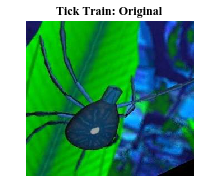

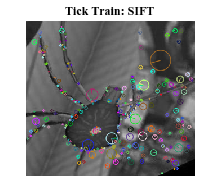

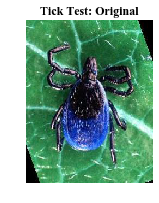

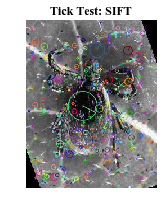

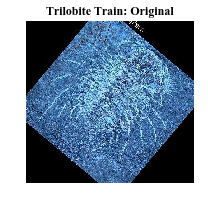

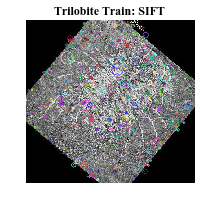

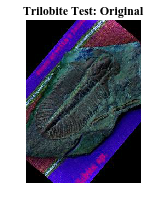

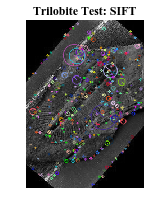

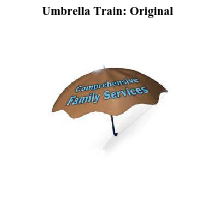

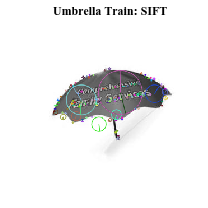

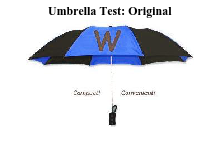

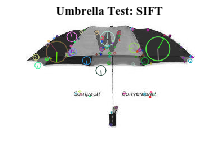

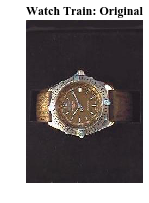

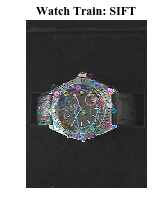

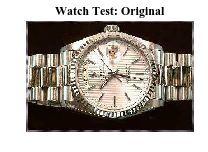

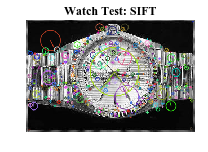

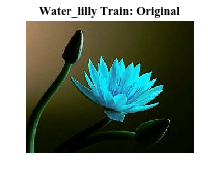

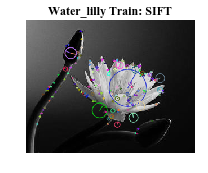

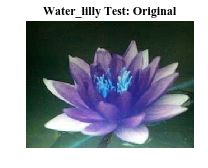

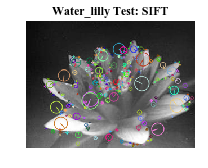

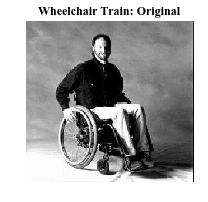

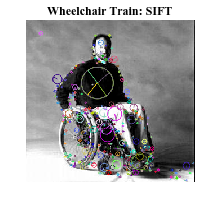

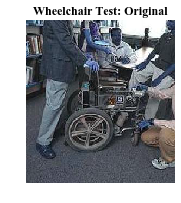

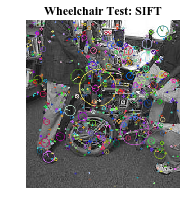

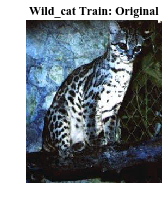

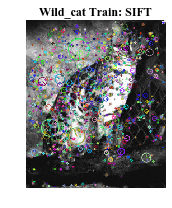

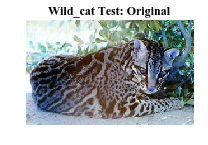

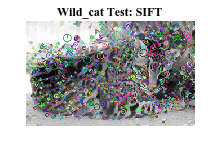

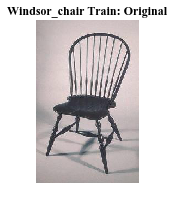

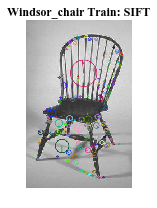

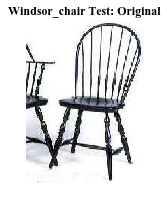

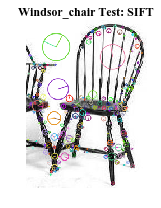

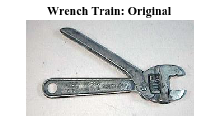

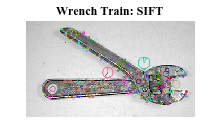

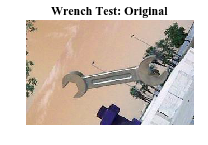

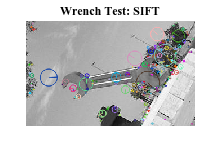

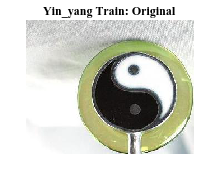

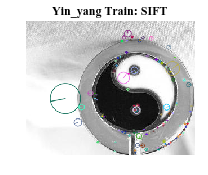

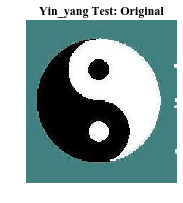

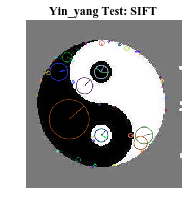

In [12]:
# EXECUTION TIME: 28s

# Python 3 ImportError
import sys
sys.path.append('.')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

import src as ya
from src.struct import ForestParams

# prettify plots
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

b_sns, g_sns, r_sns, p_sns, y_sns, l_sns = sns.color_palette("muted")

np.random.seed(1)

###########################################################################
# Visualize Raw & SIFT Training/Testing Samples from Caltech_101
###########################################################################

# set all hyperparameters to small values to speed codebook generation
# since only interested in images generated at folder `assets/3.1/examples`
data_train, data_query = ya.data.getCaltech(savefig_images=True,
                                            num_descriptors=2,
                                            pickle_load=False,
                                            pickle_dump=False,
                                            num_features=2)

| 002 DONE |
| 004 DONE |
| 016 DONE |


KeyboardInterrupt: 

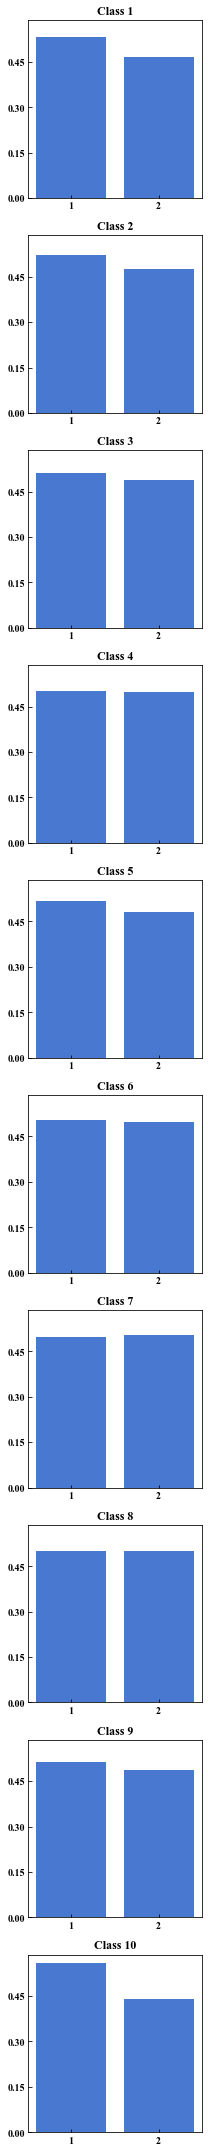

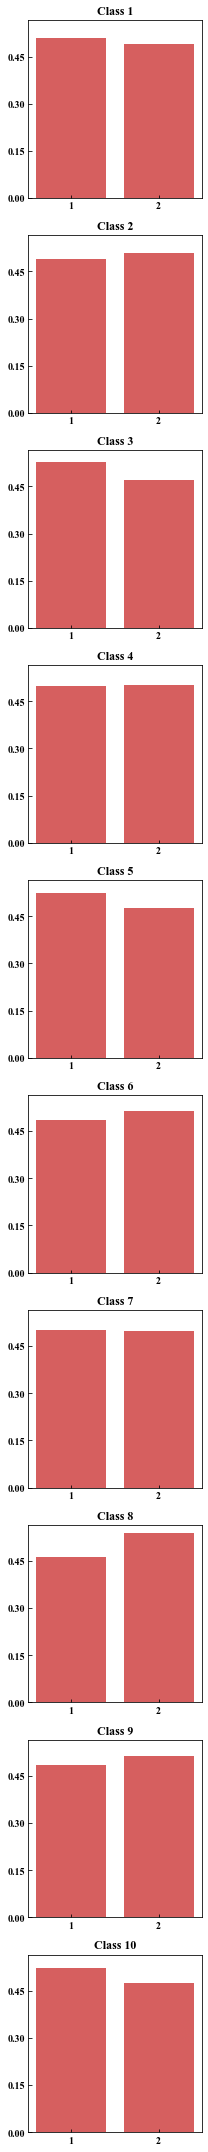

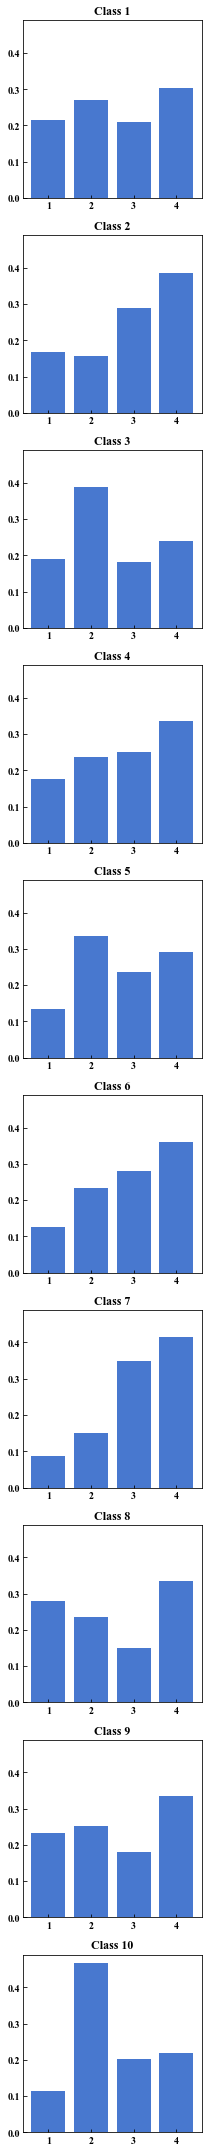

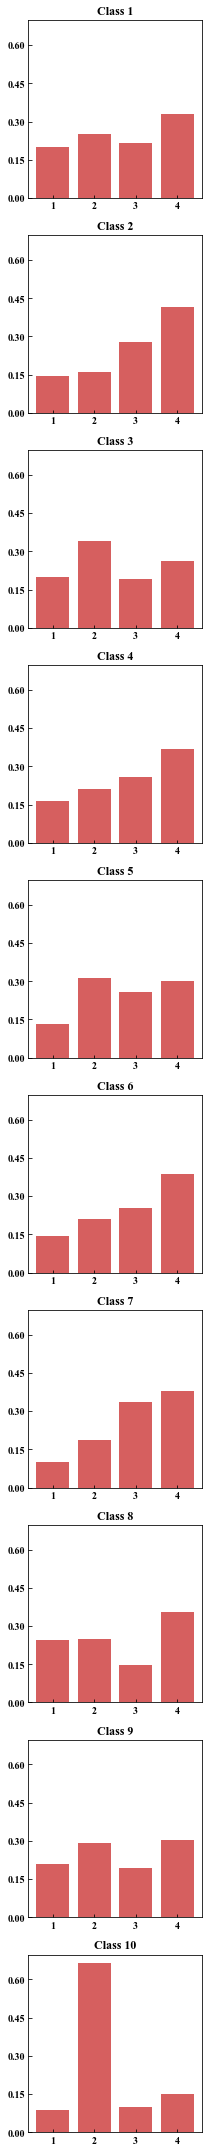

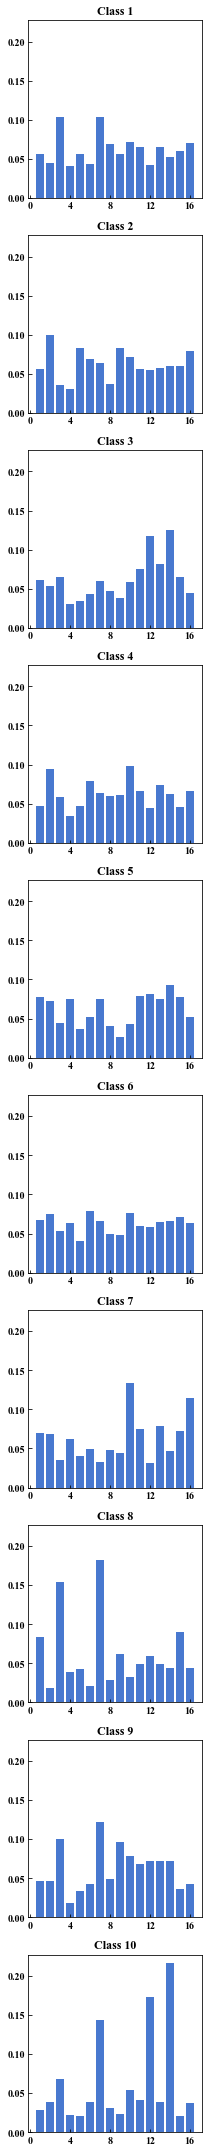

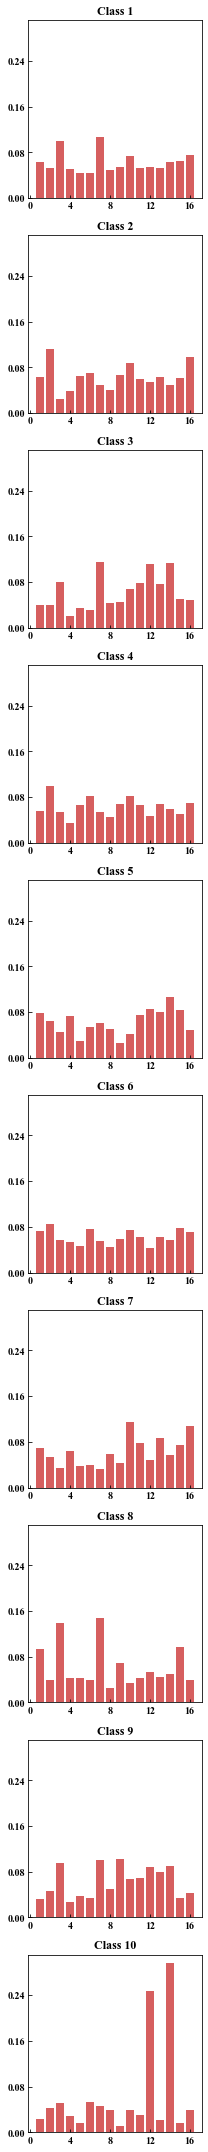

In [13]:
# EXECUTION TIME: 19m7s

# Python 3 ImportError
import sys
sys.path.append('.')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

import src as ya
from src.struct import ForestParams

# prettify plots
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

b_sns, g_sns, r_sns, p_sns, y_sns, l_sns = sns.color_palette("muted")

np.random.seed(1)

###########################################################################
# Centroids Vector Quantization
###########################################################################

for num_features in [2, 4, 16, 64, 128, 256, 512]:
    data_train, data_query = ya.data.getCaltech(num_descriptors=1e5,
                                                pickle_load=False,
                                                pickle_dump=False,
                                                num_features=num_features)
    # TRAINING
    X_train, y_train = data_train[:, :-1], data_train[:, -1]
    class_list = np.unique(y_train)
    fig, axes = plt.subplots(nrows=len(class_list),
                             figsize=(3.0, 3.0*len(class_list)), sharey=True)
    for image_class, ax in zip(class_list, axes.flatten()):
        imgs = X_train[y_train == image_class]
        average_features = np.mean(imgs, axis=0)
        ax.bar(range(1, num_features+1),
               average_features, color=b_sns)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_title('Class %i' % (image_class + 1))
    fig.tight_layout()
    fig.savefig('assets/3.1/bar/train/%i.pdf' % (num_features),
                format='pdf',
                dpi=300,
                transparent=True,
                bbox_inches='tight',
                pad_inches=0.01)
    # TESTING
    X_test, y_test = data_query[:, :-1], data_query[:, -1]
    class_list = np.unique(y_test)
    fig, axes = plt.subplots(nrows=len(class_list),
                             figsize=(3.0, 3.0*len(class_list)), sharey=True)
    for image_class, ax in zip(class_list, axes.flatten()):
        imgs = X_test[y_test == image_class]
        average_features = np.mean(imgs, axis=0)
        ax.bar(range(1, num_features+1),
               average_features, color=r_sns)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_title('Class %i' % (image_class + 1))
        plt.setp(ax.get_yticklabels(), visible=True)
    fig.tight_layout()
    fig.savefig('assets/3.1/bar/test/%i.pdf' % (num_features),
                format='pdf',
                dpi=300,
                transparent=True,
                bbox_inches='tight',
                pad_inches=0.01)
    print('| %03d DONE |' % num_features)


 \begin{tabular}{llll}
\toprule
{} & KMeans Execution Time & MiniBatchKMeans Execution Time & Inertia Delta \\
\midrule
2000.000000   &              0.751281 &                       0.408792 &       628.694 \\
3494.949495   &              0.697558 &                       0.370783 &        137.54 \\
4989.898990   &              0.559426 &                       0.497575 &       17.4877 \\
6484.848485   &              0.586886 &                       0.169812 &       1191.87 \\
7979.797980   &              0.563675 &                        0.23436 &        11.351 \\
9474.747475   &              0.598171 &                       0.109365 &       204.663 \\
10969.696970  &              0.627029 &                       0.109368 &       232.096 \\
12464.646465  &               0.60929 &                       0.062495 &       137.509 \\
13959.595960  &              0.611734 &                       0.189935 &       17.5182 \\
15454.545455  &              0.770498 &                       0.16841

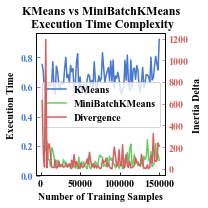

In [14]:
# EXECUTION TIME: 1m12s

# Python 3 ImportError
import sys
sys.path.append('.')

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.datasets.samples_generator import make_blobs

# prettify plots
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

b_sns, g_sns, r_sns, p_sns, y_sns, l_sns = sns.color_palette("muted")

# #############################################################################
# Comparison Matrix
n_samples = np.linspace(2000, 150000, 100)
df = pd.DataFrame(index=n_samples, columns=[
                  "KMeans Execution Time",
                  "MiniBatchKMeans Execution Time",
                  "Inertia Delta"])

centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)

for samples in n_samples:
    # Generate sample data
    np.random.seed(0)

    batch_size = int(samples // 100)
    X, labels_true = make_blobs(
        n_samples=50000, centers=centers, cluster_std=0.7)

    # Compute clustering with Means
    k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
    t0 = time.time()
    k_means.fit(X)
    t_batch = time.time() - t0

    # Compute clustering with MiniBatchKMeans
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=3,
                          batch_size=batch_size, n_init=10,
                          max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(X)
    t_mini_batch = time.time() - t0

    df.loc[samples] = [t_batch, t_mini_batch,
                       np.abs(k_means.inertia_ - mbk.inertia_)]

print('\n', df.to_latex(), '\n')
df.to_csv('assets/3.1/kmeans/complexity.csv')

fig, ax1 = plt.subplots()

lns1 = ax1.plot(n_samples, df["KMeans Execution Time"],
                label="KMeans", color=b_sns)
lns2 = ax1.plot(n_samples, df["MiniBatchKMeans Execution Time"],
                label="MiniBatchKMeans", color=g_sns)
plt.legend()
ax1.set_xlabel('Number of Training Samples')
ax1.set_ylabel('Execution Time')
ax1.set_title('KMeans vs MiniBatchKMeans\n Execution Time Complexity')
ax1.tick_params('y', colors=b_sns)

ax2 = ax1.twinx()
lns3 = ax2.plot(n_samples, df["Inertia Delta"],
                label="Divergence", color=r_sns)
ax2.set_ylabel('Inertia Delta')
ax2.tick_params('y', colors=r_sns)

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()
fig.savefig('assets/3.1/kmeans/time.pdf', format='pdf', dpi=300,
            transparent=True, bbox_inches='tight', pad_inches=0.01)